# K-Means


The pinguins are back! Use K-Means to find groups from the penguins dataset. Do they correspond to the true labels?

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [2]:
import pandas as pd
import seaborn as sns 
from palmerpenguins import load_penguins
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
sns.set_style('whitegrid')

In [3]:
penguins = load_penguins()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [4]:
penguins = penguins.dropna()

In [5]:
X = penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']]

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# TODO train a k-means model. What k are you looking for?

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Función de K-means
def kmeans(X, k, max_iters=100): #doy como input los datos, los k que quiero y las iteraciones maximas
    centroids = X[np.random.choice(len(X), k, replace=False)] #elijo k centroides iniciales aleatorios
    for i in range(max_iters): #para i en el numero maximo de iteraciones
        clusters = [[] for _ in range(k)] #para guardar los puntos asociados a cada uno de los 5 clusters
        for x in X: #para los puntos en mis datos
            distances = np.linalg.norm(x - centroids, axis=1) #calculo la distancia euclidiana entre los datos y los centroides
            cluster_idx = np.argmin(distances) #escojo la minima distancia entre mi x actual y los k centroides
            clusters[cluster_idx].append(x) #guardo de acuerdo a la minima distancia cada cluster
        new_centroids = [] #centroides acualizados
        for j in range(k): #para los 5 clusters
            new_centroid = np.mean(clusters[j], axis=0) #calculo la media de cada centroide
            new_centroids.append(new_centroid) #esta media sera mi nuevo centroide
        if (np.array(centroids) == np.array(new_centroids)).all(): #si los centroides actaules son iguales a los nuevos
            break #termina
        else:
            centroids = new_centroids #si no son los mismos continua hasta que sean los mismos
    return clusters, centroids

clusters, centroids = kmeans(X, k=5, max_iters=100)

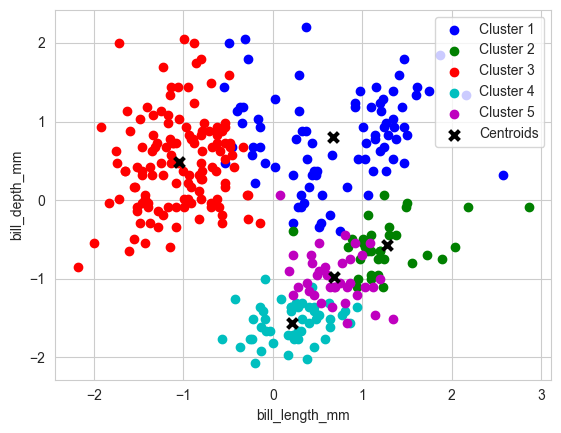

In [8]:
#Make a plot where the color is the label assigned by the clustering
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i in range(len(clusters)):
    cluster = np.array(clusters[i])
    plt.scatter(cluster[:,0], cluster[:,1], c=colors[i%len(colors)], label=f'Cluster {i+1}')

plt.scatter(np.array(centroids)[:,0], np.array(centroids)[:,1], marker='x', s=50, linewidths=3, color='k', zorder=10, label='Centroids')
plt.xlabel('bill_length_mm')
plt.ylabel('bill_depth_mm')
plt.legend()
plt.show()

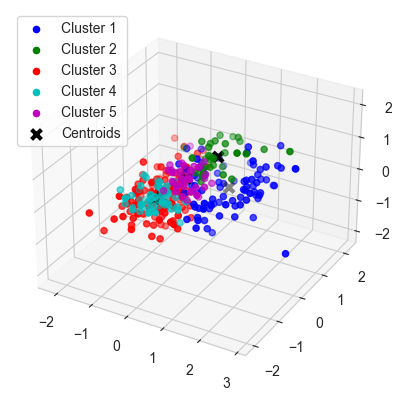

In [9]:
#Make a 3D plot where the color is the label assigned by the clustering
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(clusters)):
    cluster = np.array(clusters[i])
    ax.scatter(cluster[:,0], cluster[:,1], cluster[:,2], c=colors[i%len(colors)], label=f'Cluster {i+1}')

ax.scatter(np.array(centroids)[:,0], np.array(centroids)[:,1], np.array(centroids)[:,2], marker='x', s=50, linewidths=3, color='k', zorder=10, label='Centroids')
ax.legend()
plt.show()

In [10]:
#TODO To which label each class correspond? Search about scipy linear_sum_assignment
#It is an optimization problem.
#Show the table

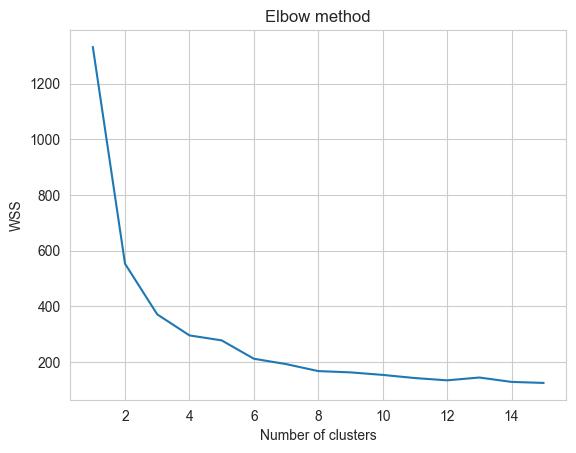

In [11]:
#TODO Do the elbow method for different k's
def sum_distances(points, centers):
    #calculo la distancia entre los todos losa datos y los centroides obtenidos en kmeans
    distances = np.linalg.norm(points - centers[:, np.newaxis], axis=2)
    #asigno cada punto al centroide mas cercano
    assignments = np.argmin(distances, axis=0)
    #calculo la suma de las distancias dentro de cada cluster
    inside_sum = np.sum((points - centers[assignments]) ** 2, axis=1)
    return np.sum(inside_sum)

def elbow_method(X, max_k):
    values = []
    for k in range(1, max_k+1):
        clusters, centroids = kmeans(X, k=k, max_iters=100)
        centroids = np.array(centroids)
        sums = sum_distances(X, centroids)
        values.append(sums)
    # Plot WSS values against number of clusters
    plt.plot(range(1, max_k+1), values)
    plt.xlabel('Number of clusters')
    plt.ylabel('WSS')
    plt.title('Elbow method')
    plt.show()
    
elbow_method(X, max_k=15)

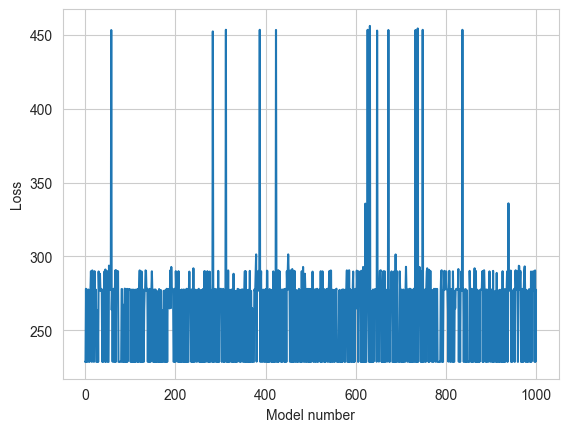

Best loss: 228.50646182972235


In [12]:
#TODO train 1000 models, with random initialization. Plot the results of the losses
losses = []
for i in range(1000):
    clusters, centroids = kmeans(X, k=5, max_iters=100)
    loss = 0
    for j in range(5):
        loss += np.sum((np.array(clusters[j]) - centroids[j])**2)
    losses.append(loss)

plt.plot(losses)
plt.xlabel('Model number')
plt.ylabel('Loss')
plt.show()

In [13]:
#TODO train 1000 models, with a better initialization. Plot the results of the losses

def kmeans_plus(X, k, max_iters=100):
    # Inicializar los centroides usando k-means++
    n, d = X.shape
    centroids = np.zeros((k, d))
    centroids[0] = X[np.random.randint(n)]
    for i in range(1, k):
        distances = np.array([min([np.linalg.norm(x-c)**2 for c in centroids]) for x in X])
        probabilities = distances / distances.sum()
        cumulative_probabilities = probabilities.cumsum()
        r = np.random.rand()
        for j, cp in enumerate(cumulative_probabilities):
            if r < cp:
                centroids[i] = X[j]
                break

    # Ejecutar el algoritmo k-means
    for i in range(max_iters):
        # Asignar cada punto al centroide más cercano
        clusters = [[] for _ in range(k)]
        for x in X:
            distances = np.linalg.norm(x - centroids, axis=1)
            cluster_idx = np.argmin(distances)
            clusters[cluster_idx].append(x)

        # Calcular los nuevos centroides
        new_centroids = []
        for j in range(k):
            if len(clusters[j]) == 0:
                # Si un clúster está vacío, no se mueve el centroide
                new_centroids.append(centroids[j])
            else:
                new_centroid = np.mean(clusters[j], axis=0)
                new_centroids.append(new_centroid)

        # Verificar si los centroides han convergido
        if (np.array(centroids) == np.array(new_centroids)).all():
            break
        else:
            centroids = new_centroids

    return clusters, centroids

In [15]:
clusters_plus, centroids_plus = kmeans_plus(X, k=5, max_iters=100)

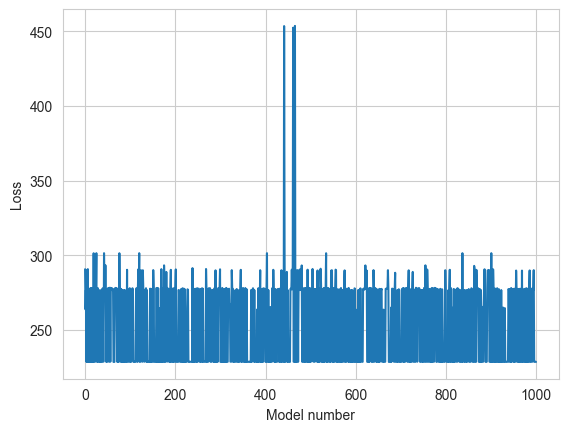

Best loss: 228.50646182972235


In [16]:
losses_plus = []
for i in range(1000):
    clusters_plus, centroids_plus = kmeans_plus(X, k=5, max_iters=100)
    loss = 0
    for j in range(5):
        loss += np.sum((np.array(clusters_plus[j]) - centroids_plus[j])**2)
    losses_plus.append(loss)

plt.plot(losses_plus)
plt.xlabel('Model number')
plt.ylabel('Loss')
plt.show()

We have already seen the K-Means class. We know that it can help us to reduce dimensionality and understand how the data behave. We can use it for finding groups and classify them. Now, we are going to use it to do image segmentation.  

What do you think are the data points?  
How can we evaluate each point?  
How is different an image from a normal matrix of data?  

We are going to use RGB images. They have three channels and we must take those into account while computing the groups.

<img src="three_d_array.png" alt="three_d_array" width="300"/>

This time, you will have to implement K-Means by hand, do not use the sklearn. How can you define the centroids?

In [ ]:
#Import libraries
from skimage import io
from skimage import color

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
%matplotlib inline
import requests

In [ ]:
#Download image. Feel free to change the image. Remember that we are working with RGB images.
url = "https://www.rainforest-alliance.org/wp-content/uploads/2021/06/poison-dart-frog-thumb-1-400x400.jpg"
img_data = requests.get(url).content
with open('image.jpg', 'wb') as handler:
    handler.write(img_data)
img = io.imread("image.jpg")

In [ ]:
#Show image
plt.imshow(img)
plt.axis("off")

In [ ]:
#Check the shape of the image. If there are more or less channels, we might have an image in another format
img.shape

In [ ]:
#Show just the blue channel
plt.imshow(img[:,:,2])

In [ ]:
#TODO Feel free to change the method definition and documentation, you can create the method that you need

#Method for computing the new centroids. The parameters are:
#     - centroids. Current centroids.
#     - data. data[0] will contain the image
#             data[1] will contain the current label or centroid
# Returns the new centroids. The data and labels do not change.
def compute_centroids(centroids,data):
    #For each centroid, calculate the new center, by finding the mean of the data points in each channel.

    return None

In [ ]:
#TODO Feel free to change the method definition and documentation, you can create the method that you need

#Method for assigning the points to a new centroid. The parameters are:
#     - centroids. Current centroids.
#     - data. data[0] will contain the image
#             data[1] will contain the current label or centroid
# Returns the new labels. The points are assigned based on Euclidean distance.
def assign(centroids,data):

    return None

In [ ]:
#TODO Feel free to change the method definition and documentation, you can create the method that you need

#Method that implements K-Means. The parameters are:
#     - k. The problem with K-Means is that it needs a hyperparameter k, selected by the user.
#     - image. 
#Returns a segmented image.
def k_means(k,image):
    #Generate the centroids. Randomly. Our centroids are three dimensional.
    centroids = {i+1:[np.random.randint(255),np.random.randint(255),np.random.randint(255)]for i in range(k)}
    
    return new_i

In [ ]:
#Get 8 new images, with a different number of clusters
images = []
for k in range(1,9):
    images.append(k_means(k,img))

In [ ]:
#Method for showing the comparison of the images
def print_images(imagenes):
    #Configuration of the plot
    plt.figure(figsize=(15, 10))
    plt.subplot(np.ceil(len(imagenes)/3), 3, 1)

    #Show original image
    plt.imshow(img)
    plt.title("Imagen Original")
    plt.axis("off")

    #Show the segmented images
    for idx in range(len(imagenes)):
        plt.subplot(np.ceil(len(imagenes)/3), 3, 2 + idx)
        plt.imshow(imagenes[idx].astype('uint8'))
        plt.title(f"{idx+1} Colors")
        plt.axis("off")
    plt.show()

In [ ]:
print_images(images)

In [ ]:
plt.imshow(k_means(15,img))